#### Importing libraries

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from collections import Counter
import missingno
from sklearn.impute import KNNImputer
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix, log_loss, plot_roc_curve, auc, precision_recall_curve
from sklearn.cluster import KMeans
from sklearn.model_selection import StratifiedKFold 
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, precision_score, f1_score
%matplotlib inline
from xgboost import XGBClassifier
from functools import partial
from skopt import gp_minimize
from skopt import space
from skopt.plots import plot_convergence
from scipy.stats import ks_2samp

C:\Users\Rikoo\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


#### Importing the data 

In [2]:
train = pd.read_csv('aug_train.csv')
test = pd.read_csv('aug_test.csv')
sample = pd.read_csv('sample_submission.csv')

## Exploratory Data Analysis

### Initial look at the data

In [3]:
train.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [4]:
test.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,32403,city_41,0.827,Male,Has relevent experience,Full time course,Graduate,STEM,9,<10,NaN,1,21
1,9858,city_103,0.920,Female,Has relevent experience,no_enrollment,Graduate,STEM,5,NaN,Pvt Ltd,1,98
2,31806,city_21,0.624,Male,No relevent experience,no_enrollment,High School,NaN,<1,NaN,Pvt Ltd,never,15
3,27385,city_13,0.827,Male,Has relevent experience,no_enrollment,Masters,STEM,11,10/49,Pvt Ltd,1,39
4,27724,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,10000+,Pvt Ltd,>4,72


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2129 entries, 0 to 2128
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             2129 non-null   int64  
 1   city                    2129 non-null   object 
 2   city_development_index  2129 non-null   float64
 3   gender                  1621 non-null   object 
 4   relevent_experience     2129 non-null   object 
 5   enrolled_university     2098 non-null   object 
 6   education_level         2077 non-null   object 
 7   major_discipline        1817 non-null   object 
 8   experience              2124 non-null   object 
 9   company_size            1507 non-null   object 
 10  company_type            1495 non-null   object 
 11  last_new_job            2089 non-null   object 
 12  training_hours          2129 non-null   int64  
dtypes: float64(1), int64(2), object(10)
memory usage: 216.4+ KB


We can see that there are 14 columns.The column enrollee_id is an indentifier, target is the value we will try to predict, this leaves us with 12 features. Out of these 12 features 10 of them are categorical. Some of the categorical features are ordinal (they have a natural ordering) and some are nominal (no order between values).
- Nominal(city, gender, relevant_experience (binary), enrolled_university (binary), major_discipline)
- Ordinal(education_level, company_size, experience, last_new_job, company_type)

We can aslo see there are missing values in our dataset

In [7]:
train.isnull().sum()

enrollee_id                  0
city                         0
city_development_index       0
gender                    4508
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
company_size              5938
company_type              6140
last_new_job               423
training_hours               0
target                       0
dtype: int64

In [8]:
test.isnull().sum()

enrollee_id                 0
city                        0
city_development_index      0
gender                    508
relevent_experience         0
enrolled_university        31
education_level            52
major_discipline          312
experience                  5
company_size              622
company_type              634
last_new_job               40
training_hours              0
dtype: int64

##### In order to make these features usable by machine learning algorithms we need to encode them into a numerical form as well as handle missing values

We will now combine the train and test datasets in order to preprocess them easier

# Data preprocessing

In [9]:
#create a target column with -1 as values in order to be able to distinguish the training from the test set later on
test['target'] = -1 #remeber that we have to drop this column later

pre = pd.concat([train, test], axis = 0).reset_index(drop = True)

### Checking for null values before encoding the categorical data

In [10]:
# Percentage of missing values in each column
round(pre.isna().sum()/len(train) *100,2)

enrollee_id                0.00
city                       0.00
city_development_index     0.00
gender                    26.18
relevent_experience        0.00
enrolled_university        2.18
education_level            2.67
major_discipline          16.31
experience                 0.37
company_size              34.24
company_type              35.36
last_new_job               2.42
training_hours             0.00
target                     0.00
dtype: float64

- -1 - Exact Negative correlation represents that if the value of one variable is present then the value of other variables is definitely absent.
- 0 - No correlation represents that variables values present or absent do not have any effect on one another.
- 1 - Exact Positive correlation represents that if the value of one variable is present then the value of the other is definitely present.

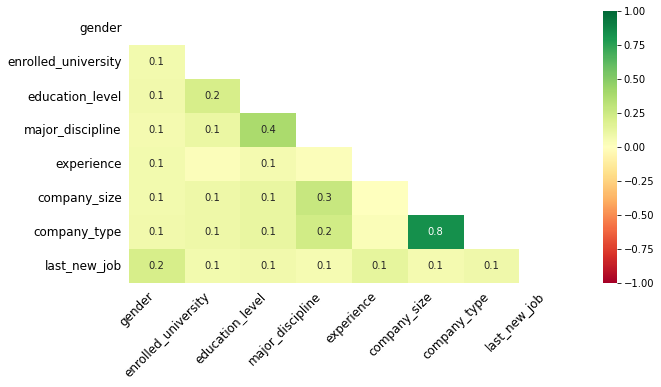

In [11]:
# Plot shows the correlation between missing values
missingno.heatmap(pre, cmap="RdYlGn", figsize=(10,5), fontsize=12);

### Mapping categorical data

We can map ordinal values using a dictionary. For now we will map the nominal values using dictionaries as well. Later we will revert them to their original values and encode them differently. We need to do this in order to use the knn imputation method for handling missing values.

In [12]:
# Making Dictionaries of categorical features
gender_map = {
        'Female': 2,
        'Male': 1,
        'Other': 0
         }

relevent_experience_map = {
    'Has relevent experience' : 1,
    'No relevent experience' : 0
}

enrolled_university_map = {
    'no_enrollment' : 0,
    'Full time course' : 1, 
    'Part time course' : 2 
}
    
education_level_map = {
    'Primary School' : 0,
    'High School' : 1, 
    'Graduate' : 2,
    'Masters' : 3, 
    'Phd' : 4
    } 
    
major_map ={ 
    'STEM' : 0,
    'Business Degree' : 1, 
    'Arts' : 2, 
    'Humanities' : 3, 
    'No Major' : 4, 
    'Other' : 5 
}
    
experience_map = {
    '<1' : 0,
    '1' : 1, 
    '2' : 2, 
    '3' : 3, 
    '4' : 4, 
    '5' : 5,
    '6' : 6,
    '7' : 7,
    '8' : 8, 
    '9' : 9, 
    '10' : 10, 
    '11' : 11,
    '12' : 12,
    '13' : 13, 
    '14' : 14, 
    '15' : 15, 
    '16' : 16,
    '17' : 17,
    '18' : 18,
    '19' : 19, 
    '20' : 20, 
    '>20' : 21
} 
    
company_type_map = {
    'Pvt Ltd' : 0,
    'Funded Startup' : 1, 
    'Early Stage Startup' : 2, 
    'Other' : 3, 
    'Public Sector' : 4, 
    'NGO' : 5
}

company_size_map = {
    '<10' : 0,
    '10/49' : 1,
    '50-99' : 2,
    '100-500' : 3,
    '500-999' : 4,
    '1000-4999' : 5,
    '5000-9999' : 6,
    '10000+' : 7, 
}
    
last_new_job_map = {
    'never' : 0,
    '1' : 1, 
    '2' : 2, 
    '3' : 3, 
    '4' : 4, 
    '>4' : 5
}

Mapping the categorical features into numerical representation. 

In [13]:
# Transforming Categorical features into numarical features
pre.loc[:,'gender'] = pre['gender'].map(gender_map)
pre.loc[:,'relevent_experience']=pre['relevent_experience'].map(relevent_experience_map)
pre.loc[:,'education_level'] = pre['education_level'].map(education_level_map)
pre.loc[:,'company_size'] = pre['company_size'].map(company_size_map)
pre.loc[:,'company_type'] = pre['company_type'].map(company_type_map)
pre.loc[:,'last_new_job'] = pre['last_new_job'].map(last_new_job_map)
pre.loc[:,'major_discipline'] = pre['major_discipline'].map(major_map)
pre.loc[:,'enrolled_university'] = pre['enrolled_university'].map(enrolled_university_map)
pre.loc[:,'experience'] = pre['experience'].map(experience_map)

#encoding city feature using label encoder
lb_en = LabelEncoder()

pre.loc[:,'city'] = lb_en.fit_transform(pre.loc[:,'city']) 

### Handling missing values
After mapping the categorical values into a numerical representation we need to handle the missing valus in our dataset. In order to avoid dropping rows with missing values I have chosen to impute the missing values using knn (k-Nearest Neighbours) algorithm.

Creating 2 dataframes.
- df_missing( dataframe with columns where values are missing)
- df_non_missing( dataframe without columns that have missing values)

In [14]:
missing_cols = pre.columns[pre.isna().any()].tolist()

#dataframe having features with missing values
df_missing = pre[['enrollee_id'] + missing_cols]

#dataframe having features without missing values
df_non_missing = pre.drop(missing_cols, axis = 1)

Using the knn algorithm in order to fill missing values based on nearest neighbour values, in our case 3 nearest neighbours. After imputing the values we join the 2 dataframes back together and check for null values again.

In [15]:
knn_imputer = KNNImputer(n_neighbors = 3)

X = np.round(knn_imputer.fit_transform(df_missing))
#Rounding them because these are categorical features

df_missing = pd.DataFrame(X, columns = df_missing.columns)

pre = pd.merge(df_missing, df_non_missing, on = 'enrollee_id')

# Check for nulls
pre.isna().sum()/len(pre) *100

enrollee_id               0.0
gender                    0.0
enrolled_university       0.0
education_level           0.0
major_discipline          0.0
experience                0.0
company_size              0.0
company_type              0.0
last_new_job              0.0
city                      0.0
city_development_index    0.0
relevent_experience       0.0
training_hours            0.0
target                    0.0
dtype: float64

### Converting nominal columns back into their original form.
We do this because encoding them via dictionaries doesn't make sense since we are introducing artificial ordering

In [16]:
rev_gender_map = {
    2:'Female',
    1:'Male',
    0:'Other'
         }
rev_major_map ={ 
    0:'STEM',
    1:'Business Degree',
    2:'Arts',
    3:'Humanities',
    4:'No Major',
    5:'Other'
}
rev_company_type_map = {
    0:'Pvt Ltd',
    1:'Funded Startup', 
    2:'Early Stage Startup', 
    3:'Other', 
    4:'Public Sector', 
    5:'NGO'
}
pre.loc[:,'gender'] = pre['gender'].map(rev_gender_map)
pre.loc[:,'major_discipline'] = pre['major_discipline'].map(rev_major_map)
pre.loc[:,'company_type'] = pre['company_type'].map(rev_company_type_map)

### Examining the nominal columns further in order to see if we can do some feature engineering

In order to avoid imposing a false sense of ordinal relationship (eg. 13>1) we have to encode nomnial values differently. One such approach is One-Hot Encoding or dummy encoding. We will be using dummy encoding.
We are left with enumerating the following nominal values:
- city 
- gender 
- major_discipline 
- company_type 


##### As the number of features grows, the amount of data we need to accurately be able to distinguish between these features and generalize our model grows EXPONENTIALLY. (Curse of dimensionality)
If we use dummy encoding without first preprocessing these columns we will get a large amount of columns (mostly because of the city column) and this in turn might cause the curse of dimensionality. In order to use dummy encoding on the city column we will keep the values for the first 5 value ranked by frequency, and set all the other values to "other". Now we will generate the new columns as well as drop unnecesary columns from the dataframe.

Most of the gender values are Male. We will add the values from the "Other" category to the "Female" category.

Male      19549
Female     1521
Other       217
Name: gender, dtype: int64

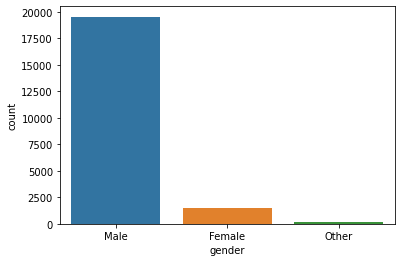

In [17]:
sns.countplot(x=pre['gender'])
pre['gender'].value_counts()


In [18]:
# Changing 'Other' to 'Female'
pre['gender']=np.where((pre['gender'] == 'Other'), 'Female', pre['gender'])

Most of the major_discipline values are "STEM". This is a valuable insight since we can group all of the other values under "Other" and in return get a lower number of columns once we encode them using dummy encoding

STEM               18390
Business Degree      925
Humanities           783
Arts                 522
Other                421
No Major             246
Name: major_discipline, dtype: int64

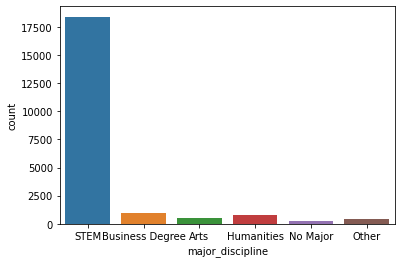

In [19]:
sns.countplot(x=pre['major_discipline'])
pre['major_discipline'].value_counts()

In [20]:
# Changing non 'STEM' values to 'Other'
pre['major_discipline']=np.where((pre['major_discipline'] != 'STEM'), 'Other', pre['major_discipline'])

Most of the company_type values are "Pvt Ltd". We will group other values under "Other" for the same reason of having fewer columns.

Pvt Ltd                14670
Funded Startup          2899
Early Stage Startup     1630
Public Sector           1107
NGO                      583
Other                    398
Name: company_type, dtype: int64

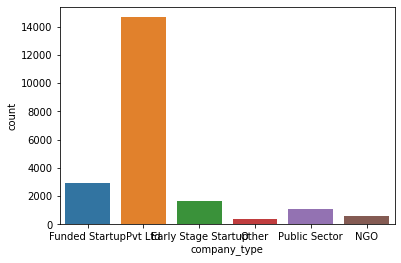

In [21]:
sns.countplot(x=pre['company_type'])
pre['company_type'].value_counts()

In [22]:
# Changing non 'Pvt Ltd' values to 'Other'
pre['company_type']=np.where((pre['company_type'] != 'Pvt Ltd'), 'Other', pre['company_type'])

Looking at the city values we can see that we will have to do something similar for this coulmn aswell.

<AxesSubplot:xlabel='city', ylabel='count'>

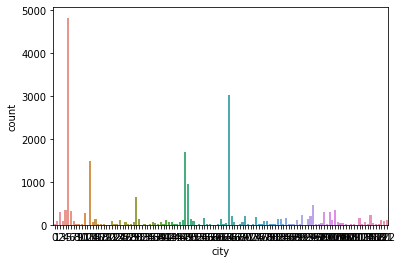

In [23]:
sns.countplot(x=pre['city'])

In [24]:
#Percentage of each unique city value 
print(pre['city'].value_counts(normalize=True).mul(100).round(1).head(10))

5      22.7
64     14.2
48      8.0
13      7.0
49      4.5
30      3.0
95      2.2
103     1.6
4       1.6
6       1.5
Name: city, dtype: float64


In [25]:
pre['city']=np.where((pre['city'] != 5) & (pre['city'] != 64) & (pre['city'] != 48) & (pre['city'] != 13) & (pre['city'] != 49) , 'Other', pre['city'])

After processing these features we can do dummy encoding in order to prepare them for the machine learning algorithm

In [26]:
# generate binary values using get_dummies
pre=pd.get_dummies(pre, columns=["city"], prefix=["city"])
pre=pd.get_dummies(pre, columns=["gender"], prefix=["gender"] )
pre=pd.get_dummies(pre, columns=["major_discipline"], prefix=["major_discipline"] )
pre=pd.get_dummies(pre, columns=["company_type"], prefix=["company_type"] )

### Checking if our train and test datasets come from the same distribution

This check is crucial since in order to have effective evaluations as well as to build a good classifier we must ensure our train and test data come from the same distribution otherwise we will effectivly be overfitting to the training distribution.

We split the processed data into train and test. We then use the Kolomogorov-Smirnov test to determine if the train and test data come from the same distribution. The first value is the D statistic. The D statistic is the absolute max distance (supremum) between the CDFs of the two samples.
##### Since all of the D statistics values are close to 0 we can infer that the train and test data come from the same distribution.

In [27]:
train_copy = pre[pre['target'] != -1].reset_index(drop = True)
test_copy = pre[pre['target'] == -1].reset_index(drop = True)

# drop fake target feature from test data 
train_copy = train_copy.drop('target', axis = 1)
#perform Kolmogorov-Smirnov test
for col in train_copy.columns:
    if(col=='target'):
        continue
    print(ks_2samp(train_copy[col], test_copy[col]))

KstestResult(statistic=0.010907687088129336, pvalue=0.9747201223896389)
KstestResult(statistic=0.00982200818870893, pvalue=0.9918173761783995)
KstestResult(statistic=0.010137399845864148, pvalue=0.9881859056326482)
KstestResult(statistic=0.009574774865422797, pvalue=0.9940277553184523)
KstestResult(statistic=0.012550989421189124, pvalue=0.9196383991586765)
KstestResult(statistic=0.011099437566255088, pvalue=0.9702190916435165)
KstestResult(statistic=0.020349209959099612, pvalue=0.40034985756789776)
KstestResult(statistic=0.004079104660357935, pvalue=0.999999999999999)
KstestResult(statistic=0.012458093044559693, pvalue=0.9237542799303227)
KstestResult(statistic=0.0030682528238757945, pvalue=1.0)
KstestResult(statistic=0.001108504586050607, pvalue=1.0)
KstestResult(statistic=0.008969661254551675, pvalue=0.9975440667571278)
KstestResult(statistic=0.005150146680166889, pvalue=0.9999999993241201)
KstestResult(statistic=0.008328212877207863, pvalue=0.9992378173959815)
KstestResult(statistic

### Checking the distribution of our target variable

Now we will look at the target variable distribution. If the distribution is skewed we can infer that we have an imbalanced dataset. We can see that we have many more values for y=0 so our dataset is skewed. This means we will have to use advanced evaluation metrics such as precission/recall or f1 score, instead of using accuracy. We can also use methods like SMOTE in order to balance the dataset.

<AxesSubplot:xlabel='target', ylabel='count'>

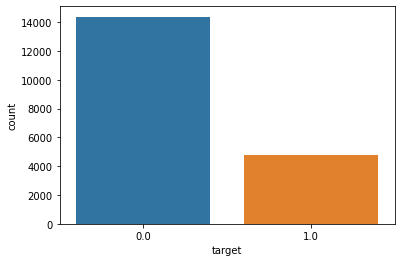

In [28]:
sns.countplot(x=train['target'])

### The correlation matrix

We can take a look at the correlation matrix to see if our features have a relationship with each other. We can see that there is not much correlation except maybe in the case of last_new_job and experience. Which makes sense since the value of last new job (in years) can indicate to some degree the experience value

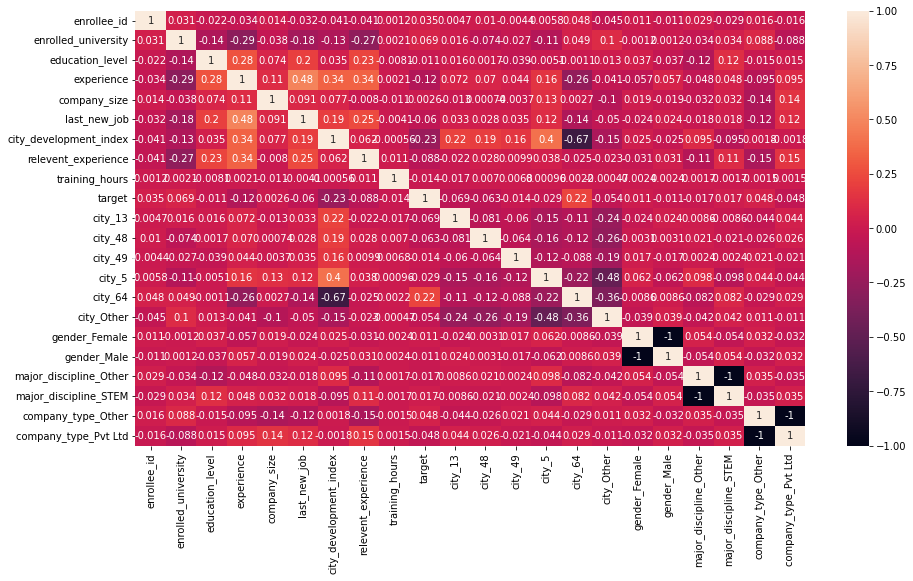

In [29]:
corr = pre.corr()
plt.figure(figsize=(15,8))
ax = sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            annot=True)


In [30]:
pre.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21287 entries, 0 to 21286
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             21287 non-null  float64
 1   enrolled_university     21287 non-null  float64
 2   education_level         21287 non-null  float64
 3   experience              21287 non-null  float64
 4   company_size            21287 non-null  float64
 5   last_new_job            21287 non-null  float64
 6   city_development_index  21287 non-null  float64
 7   relevent_experience     21287 non-null  int64  
 8   training_hours          21287 non-null  int64  
 9   target                  21287 non-null  float64
 10  city_13                 21287 non-null  uint8  
 11  city_48                 21287 non-null  uint8  
 12  city_49                 21287 non-null  uint8  
 13  city_5                  21287 non-null  uint8  
 14  city_64                 21287 non-null

# Modeling

First we split the preprocessed data back into train and test datasets. We will then split the training data into our predictors X_train (matrix) and the target y_train (vector).

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
#Split preprocessed data
train = pre[pre['target'] != -1].reset_index(drop = True)
train.drop('enrollee_id',axis=1,inplace=True)
test = pre[pre['target'] == -1].reset_index(drop = True)
#Drop fake target feature from test data 
test = test.drop('target', axis = 1)

In [32]:
%%capture --no-display
#Split predictiors and target variable
X = train.drop(['target'], axis = 1)
y = train['target']

#Handling the unbalanced dataset
smote=SMOTE(sampling_strategy='not majority')
X_sm , y_sm = smote.fit_resample(X,y)

X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size = 0.15,random_state=42)

train_loss, test_loss=[],[]

scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)
   
log_model = LogisticRegression(max_iter=400, C=1).fit(scaled_X_train,y_train)

log_prediction = log_model.predict(scaled_X_test)

xgb_model = XGBClassifier(use_label_encoder=False).fit(scaled_X_train,y_train)
xgb_prediction = xgb_model.predict(scaled_X_test)


In [33]:
print("Logistic Regression Test Results:\n")
print(classification_report(y_test, log_prediction))

print("XGBClassifier Test Results:\n")
print(classification_report(y_test, xgb_prediction))

Logistic Regression Test Results:

              precision    recall  f1-score   support

         0.0       0.78      0.89      0.83      2150
         1.0       0.87      0.75      0.80      2165

    accuracy                           0.82      4315
   macro avg       0.82      0.82      0.82      4315
weighted avg       0.82      0.82      0.82      4315

XGBClassifier Test Results:

              precision    recall  f1-score   support

         0.0       0.81      0.89      0.85      2150
         1.0       0.88      0.79      0.83      2165

    accuracy                           0.84      4315
   macro avg       0.84      0.84      0.84      4315
weighted avg       0.84      0.84      0.84      4315



In [34]:
#Function for plotting the learning curves
def plot_learning_curve(model, X, Y):
    
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 11)
    train_loss, test_loss = [], []
    
    for m in range(200,len(x_train),200):
        
        model.fit(x_train.iloc[:m,:], y_train[:m])
        y_train_prob_pred = model.predict_proba(x_train.iloc[:m,:])
        train_loss.append(log_loss(y_train[:m], y_train_prob_pred))
        
        y_test_prob_pred = model.predict_proba(x_test)
        test_loss.append(log_loss(y_test, y_test_prob_pred))
        
    plt.figure(figsize = (15,8))
    plt.plot(train_loss, 'r-+', label = 'Training Loss')
    plt.plot(test_loss, 'b-', label = 'Test Loss')
    plt.xlabel('Number Of Batches')
    plt.ylabel('Log-Loss')
    plt.legend(loc = 'best')
    plt.show()

The 2 cells bellow will plot the learning curves. This takes a few minutes.

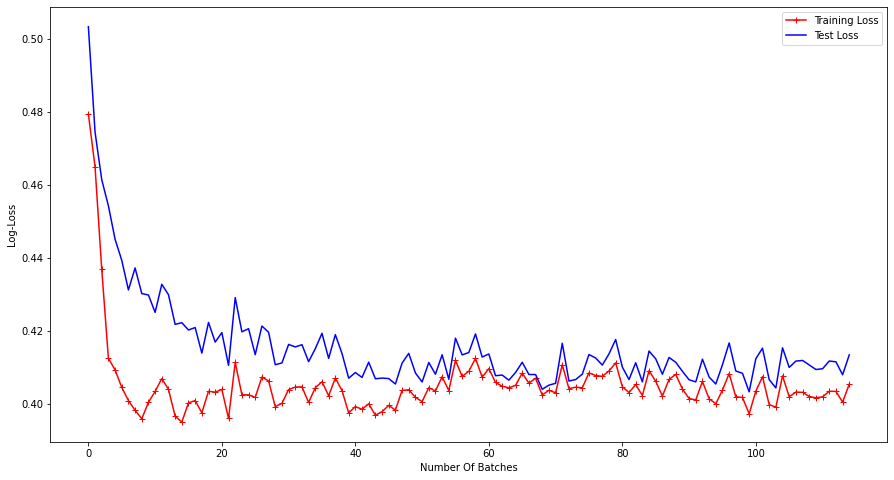

In [35]:
%%capture --no-display
plot_learning_curve(LogisticRegression(C=1,max_iter=400), X_sm, y_sm)

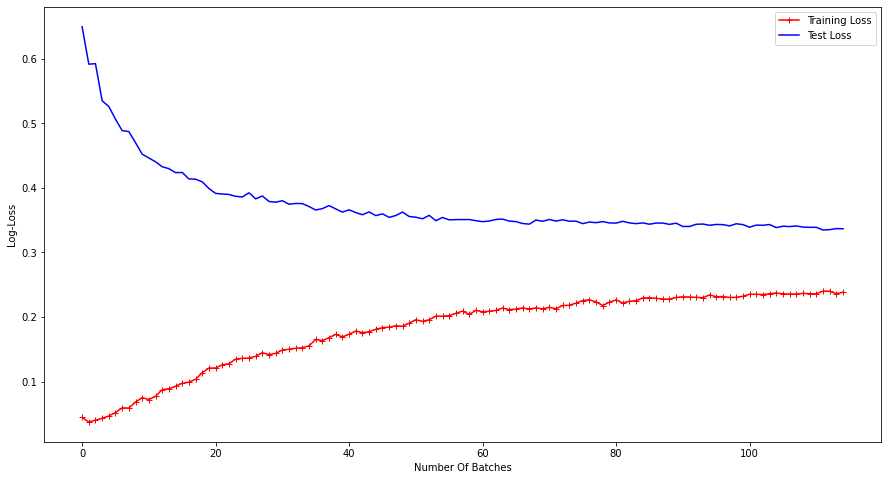

In [36]:
%%capture --no-display
%%capture --no-display
plot_learning_curve(XGBClassifier(), X_sm, y_sm)

After plotting the learning curve we can see that the XGB model has a slight variance problem. We will focus on this model and try to optimize the hyperparameters.

## Hyperparameter tunning

In [ ]:
%%capture --no-display
from sklearn.model_selection import RandomizedSearchCV
x_train, X_cv, y_train, y_cv = train_test_split(X_sm, y_sm, test_size = 0.2, random_state = 11)
xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

folds = 5
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X_cv,y_cv), verbose=3, random_state=1001 )

plot_learning_curve(random_search, X_sm, y_sm)

In [37]:
print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)
#results.to_csv('xgb-random-grid-search-results-01.csv', index=False)


 Best hyperparameters:


AttributeError: 'RandomizedSearchCV' object has no attribute 'best_params_'

In [ ]:
random_search.predict(X_sm)

ERROR! Session/line number was not unique in database. History logging moved to new session 71
